Kaggle: [https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python]

이유한_캐글필사: [https://kaggle-kr.tistory.com/32]

In [18]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

![t-test](https://user-images.githubusercontent.com/57039464/137607513-c554cfa5-a4a6-4f1a-b193-b18473c39158.png)


출처:[https://blog.naver.com/sjy5448/222480078727] <br/>
**앙상블 학습**: 여러개의 모델을 통해 얻은 예측값을 결합하여 보다 정확한 최종 예측을 도출하는 기법 <br/>
**앙상블 학습 유형**: 보팅,배깅,부스팅 <br/>
- 보팅: 다른 알고리즘의 모델들이 투표를 통해 예측 방식 결정
- 배깅: 각각의 모델들이 동일한 알고리즘을 사용하지만 데이터 샘플링을 다르게 하면서 학습을 통해 동일하게 투표를 통해 예측 방식 결정 <br/>
     - 교차검증과는 다르게 데이터 세트 간에 중첩 허용
     - 부트스트래핑: 개별 모델에게 데이터를 일부 중첩되게 샘플링해서 추출하는 방식
     - 개별 모델이 부트스트래핑 방식으로 샘플링된 데이터 세트에 대해서 학습을 통해 개별적인 예측을 수행한 결과를 보팅 방식을 통해 예측 결과를 선정 
- 부스팅: 여러개의 모델을 순차적으로 학습하지만 앞 순서에서 학습한 모델의 예측이 틀린 데이터에 대해서는 올바른 예측을 할 수 있도록 다음 모델에 가중치를 부여하면서 학습과 예측을 진행하는 방식
    - 대표적으로 그래디언트 부스트,XGBoost(eXtra Gradient Boost), LightGBM(Light Gradient Boost)가 있다. 

출처:[https://blog.naver.com/wjsduwls703/222164661392]<br/>
**Random Forest**: Decision Tree 알고리즘을 활용한 bagging 기법의 앙상블 모델로 학습 데이터를 사용하여 여러개의 decision tree를 생성 후 최종 결과를 도출하는 알고리즘이다. Decision tree는 입력 변수들에 따라 변수의 값을 예측하는 모델인데 랜덤포레스트는 이 decision Tree를 다수 생성하여 집단 학습시켜 결과를 도출한다.


출처:[https://pro-jy.tistory.com/25] <br/>
**Adaboost**: Adaptive + Boosting로 만들어진 단어. 약한 분류기(weak classifier)들이 상호보완 하도록 순차적으로 학습하고, 이들을 조합하여 최종적으로 강한 분류기의 성능을 향상시키는 것 <br/>
약한 분류기들은 한번에 하나씩 순차적으로 학습을 진행시 먼저 학습된 분류기는 제대로 분류를 해내는 데이터와 제대로 분류해내지 못하는 데이터들이 발생하게된다. 이 정보들을 분류하여 다음 분류기는 잘 분류하지 못한 데이터들의 가중치를 높인다.이전 분류기가 잘못 분류한 샘플의 가중치를 adaptive하게 바꿔가며 잘 못 분류되는 데이터에 더 집중하여 학습하게 된다. 

출처:[https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-14-AdaBoost?category=1057680] <br/>
![stump](https://user-images.githubusercontent.com/57039464/135722654-e8b2c19b-6150-4d2e-8a25-7abacb31653a.png) <br/>

약한 분류기에 대한 이해를 위해 Adaboost는 위와 같이 하나에 두개의 리프를 지닌 stump를 가지고 있습니다. 트리와 다르게 stump는 정확한 분류를 하지 못하는데 그 이유는 여러 질문을 통해 데이터를 분류하는 트리와 다르게, stump는 단 하나의 질문으로 데이터를 분류해야하기 때문입니다. 따라서 stump는 약한 학습기(weak learner)입니다.
<br/>

**Gradient Boost**: Gradient Boost는 stump나 tree가 아닌 하나의 leaf (single leaf) 부터 시작합니다. 이 leaf는 타게값에 대한 초기 추정값을 나타냅니다. 초기 추정값을 정한 후 그 후에는 AdaBoost와 동일하게 이전 tree의 error는 다음 tree에 영향을 줍니다. Adaboost와 다르게 stump가 아닌 tree로 구성되어 있으며 보통은 leaf가 8개~32개되는 tree로 구성합니다.

**ExtraTrees Classifier**: https://wyatt37.tistory.com/6

## Feature Exploration, Engineering and Cleaning

In [37]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle_필사/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_필사/test.csv')
gender_submission = pd.read_csv('/content/drive/MyDrive/Kaggle_필사/gender_submission.csv')

In [38]:
PassengerId = test['PassengerId']

#트레인 데이터 일부 확인
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [21]:
#두 데이터프레임을 한번에 전처리하기 위해 리스트화
full_data = [train,test]

# 이름길이 변수 생성
train['Name_length'] = train['Name'].apply(len) # Name 컬럼에 len 함수 적용
test['Name_length'] = test['Name'].apply(len)

# 승객이 Cabin이 있었는지 유무 확인
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1 ) # Nan의 경우 type이 float이기 때문에 Cabin이 없을시 0 부여
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

In [22]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1 #가족 수 계산, Parch의 경우 함께 탑승한 부모 또는 자녀수지만 본인을 포함하지 않고 있기 때문에 +1을 해준다

for dataset in full_data:
     dataset['IsAlone'] = 0 
     dataset.loc[dataset['FamilySize']==1,'IsAlone'] = 1 #IsAlone이라는 변수를 Family Size를 통해 만들어 준다

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S') #Embarked 중 가장 많은 데이터인 S로 빈값 채워준다

for dataset in full_data:
    dataset['Fare'].fillna(train['Fare'].median(),inplace=True) # Fare의 빈값은 중앙값으로 채워준다

#train['CategoricalFare'] = pd.qcut(train['Fare'],4) #Fare을 4개의 동일 구간으로 나눈다

# pd.cut의 경우 동일 길이로 나누기 / pd.qcut의 경우 동일 갯수로 나누기

for dataset in full_data:
    age_avg = dataset['Age'].mean() #평균
    age_std = dataset['Age'].std() #표준편차
    age_null_count = dataset['Age'].isnull().sum() #age 열의 빈값의 갯수 카운트
    #age열에 빈값이 많기 때문에 평균 - 표준편차, 평균+표준편차값으로 생성한 랜덤값을 생성하여 채워준다
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)

    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list

    dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.cut(train['Age'],5) #Age를 pd.cut을 이용하여 카테고리컬 데이터로 변환

In [23]:
def get_title(name):
      title_search = re.search(' ([A-Za-z]+)\.', name) #정규표현식을 사용해서 Mr,Mrs와 같은 타이틀 추출
      # 타이틀이 존재한다면 그 타이틀을 추출하고 리턴 시킴
      if title_search:
            return title_search.group(1)
      return ""

# passenger의 이름에서 타이틀을 추출한 title이란 새로운 피처 생성
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

#Title을 그룹화 시킴(드물게 발생하는 타이틀은 Rare로 나머지는 Miss와 Mrs,Master로만 구분)
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace((['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare'))

    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# 성을 숫자로 치환 female의 경우 0으로 male의 경우 1로
for dataset in full_data:
    # Mapping Sex

    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # 타이틀도 숫자로 치환 Mr는 1, Miss는 2,Mrs는 3, Master는 4, Rare는 5 
    title_mapping = {'Mr':1, 'Miss': 2, 'Mrs':3, 'Master': 4, 'Rare': 5}

    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Embarked 수치화
    dataset['Embarked'] = dataset['Embarked'].map( {'S' : 0, 'C': 1, 'Q': 2}).astype(int)

    # Fare도 정의한 구간으로 나눠 카테고리컬 데이터로 변환(4구간)
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
   
    # Age 카테고리컬 데이터로 변환(5개)
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age']>16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2 
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 

In [24]:
drop_elements = ['PassengerId','Name','Ticket','Cabin','SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge'],axis = 1)
test = test.drop(drop_elements, axis = 1)

In [25]:
train['Title'] = train['Title'].astype('int')

### Visualizations

In [26]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


#### Pearson Correlation Heatmap(히트맵을 통해 피어슨 상관계수 보기)

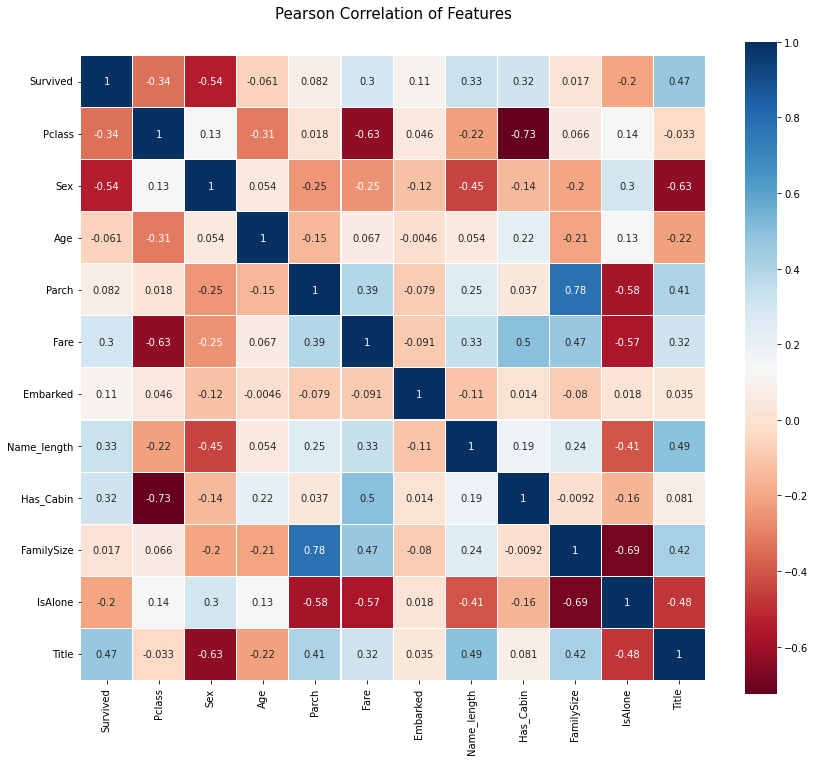

In [27]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y= 1.05, size = 15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square = True, cmap = colormap, linecolor='white',annot=True)

대체로 상관관계가 높지 않으나 Family Size와 Parch는 상관관계가 높다(Parch로 Family Size를 만든거기 때문)

#### Pairplots

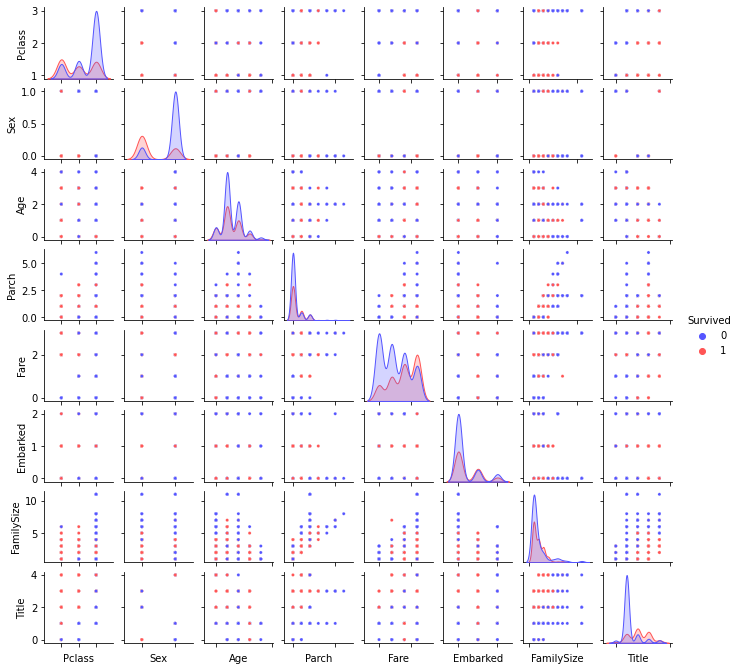

In [28]:
g = sns.pairplot(train[['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'FamilySize', 'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[]) #kde = 밀도 추정

In [39]:
configure_plotly_browser_state()
py.init_notebook_mode(connected=False)

fig = px.scatter(train, x= 'Fare',y= 'Age', color = 'Survived', size = 'Fare')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [30]:
configure_plotly_browser_state()
py.init_notebook_mode(connected=False)

fig = px.pie(train, names = 'Survived', title = 'Passenger Survival')
fig.show()
#도넛 플랏을 그리기 위해선 hole argument에 float을 넣는다

Output hidden; open in https://colab.research.google.com to view.

In [31]:
configure_plotly_browser_state()
py.init_notebook_mode(connected=False)

fig= px.pie(train, names = 'Survived', title = 'Passenger Survival',hole = 0.4)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [41]:
configure_plotly_browser_state()
py.init_notebook_mode(connected=False)

fig = go.Figure(data = [go.Pie(labels=train['Embarked'], pull =[.1,.15,0])])
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [33]:
from plotly.subplots import make_subplots

In [42]:
configure_plotly_browser_state()
py.init_notebook_mode(connected=False)

fig = make_subplots(rows=1, cols=3, specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]])
fig.add_trace(
            go.Pie(labels=train.loc[train['Embarked'] == 'C']['Survived'], pull = [.1, .1],
                   title = 'Embarked C vs. Survived'), row=1, col=1)

fig.add_trace(
            go.Pie(labels=train.loc[train['Embarked'] == 'S']['Survived'], pull = [.07, .07],
                   title = 'Embarked S vs. Survived'),row=1, col=2)

fig.add_trace(
            go.Pie(labels=train.loc[train['Embarked'] == 'Q']['Survived'], pull = [.1, .1],
                   title = 'Embarked Q vs. Survived'), row=1, col=3)


fig.update_layout(height=500, width=800, title_text="Gene Expression Features")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [43]:
configure_plotly_browser_state()
py.init_notebook_mode(connected=False)

fig = px.histogram(train, x='Age', nbins=30, marginal='box')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [46]:
configure_plotly_browser_state()
py.init_notebook_mode(connected=False)

fig = px.histogram(train, x='Age', nbins=50, histnorm='probability density')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [47]:
configure_plotly_browser_state()
py.init_notebook_mode(connected=False)

fig = px.box(train, x='Pclass', y="Age")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [49]:
configure_plotly_browser_state()
py.init_notebook_mode(connected=False)

fig = px.box(train, x='Pclass', y="Age", points="all")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [50]:
configure_plotly_browser_state()
py.init_notebook_mode(connected=False)

fig = px.box(train, x='Pclass', y="Age", notched=True, color="Survived")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

### Ensembling & Stacking models

In [ ]:
print(train.shape[0],test.shape[0])

891 418


In [ ]:
ntrain = train.shape[0] #행 갯수
ntest = test.shape[0] 
SEED = 0
NFOLDS = 5 #out-of-fold predictions을 위해 folds 설정
kf = KFold(n_splits= NFOLDS, random_state=SEED, shuffle=False)

#####K Fold란?
![다운로드 (1)](https://user-images.githubusercontent.com/57039464/136370223-25fe8580-d727-44a2-873b-4677fe2d8bd5.png)
모델의 오버피팅을 방지하기 위한 방식으로 폴드를 설정후 (위 이미지의 경우는 4번)
각 교차검증 데이터로 만들어낸 모델들로 예측을 한 후 그 예측값들의 평균으로 최종 예측값을 도출한다


In [ ]:
class SklearnHelper(object): # class 생성
  def __init__(self, clf, seed = 0, params = None): #__init__=> 초기화를 위한 함수, 데이터의 초기를 실시하는 함수
      params['random_state'] = seed # 수행시마다 동일한 결과를 얻기 위해 적용합니다.
      self.clf = clf(**params) #parameter를 몇개일지 모르기 때문에 **params 설정(?)
  
  def train(self, x_train,y_train):
      self.clf.fit(x_train, y_train) #모델을 train에 적용
  
  def predict(self, x):
      return self.clf.predict(x) #model을 통해 test 예측
  
  def fit(self,x,y):
      return self.clf.fit(x,y)
  
  def feature_importances(self,x,y):
      print(self.clf.fit(x,y).feature_importances_) #feature importance 보기

### Out-of-Fold Predictions

In [ ]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,)) #train의 행의 갯수만큼의 0생성
    oof_test = np.zeros((ntest,)) #test의 행의 갯수만큼의 0 생성
    oof_test_skf = np.empty((NFOLDS,ntest)) #

    for i, (train_index, test_index) in enumerate(kf.split(train)):
      x_tr = x_train[train_index]
      y_tr = y_train[train_index]
      x_te = x_train[test_index]

      clf.train(x_tr,y_tr)

      oof_train[test_index] = clf.predict(x_te)
      oof_test_skf[i,:] = clf.predict(x_test)
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1,1)

### 첫번째 레벨의 베이스 모델 생성

1. Random Forest Classifier
2. Extra Trees classifier
3. AdaBoost classifier
4. Gradient Boosting classifier
5. Support Vector Machine

출처: [https://wooono.tistory.com/102]

#### **하이퍼 파라미터 튜닝**:
모델을 학습하기 위해 사전 설정해야 하는 하이퍼 파라미터의 최적값을 탐색하는 방법 <br/>
**1. Manual Search**: 직관 또는 대중적으로 잘 알려진 방식으로 하이퍼 파라미터를 설정하고 이들을 활용하여 학습을 수행한 후 검증 데이터셋에 대하여 측정한 성능 결과를 기록. 이와 같이 하이퍼 파라미터를 직접 탐색하는 방식

**2. Grid Search**: 탐색 대상이 되는 특정 구간 내의 후보 하이퍼 파라미터들을 일정한 간격을 두고 선정 후 각 결과를 기록 후 가장 좋은 성능을 보인 하이퍼 파라미터들을 선정

**3. Random Search**: Grid Search와 큰 틀은 유사하나 탐색 대강 구간 내의 후보 하이퍼 파라미터 값들을 랜덤 샘플링을 통해 선정한다. 모든 grid를 전부 찾는 대신 random하기 일부 parameter들만 관측한 후 그 중에서 가장 좋은 parameter를 고른다.

**4. Bayesian Optimization**: 어느 입력값(x)를 받는 미지의 목적 함수(f(x))를 상정 후 함숫값(f(x))을 최대로 만드는 최적해를 찾는 것을 목적으로 함<br/>
  - 목적 핫무와 하이퍼 파라미터 쌍을 대상으로 Surrogate Model을 만든 후
  - 순차적으로 하이퍼 파라미터를 업데이트해 가면서 평가를 통해 최적의 하이퍼 파라미터 조합을 탐색
  - 목점 함수를 black-box function 이라고 한다.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
rf_params = {
    'n_jobs': [-1],
    'n_estimators': [300,400,500],
    'warm_start': [True],  #True로 설정시 사이킷런의 fit() 메스다가 호출될때 기존트리를 유지하고 훈련을 추가할 수 있도록 하는 기능
    'max_depth' : [2,4,6],
    'min_samples_leaf' : [1,2,3,4],
    'max_features' : ['sqrt'], # sqaure root
    'verbose':[0]
}

In [ ]:
cross_valid_scores = {}

In [ ]:
model_random_forest = GridSearchCV(
    RandomForestClassifier(
    random_state=SEED,
    class_weight='balanced',
), 
    rf_params, 
    cv=5,
    scoring='accuracy',
)

model_random_forest.fit(x_train, y_train)

print('-----')
print(f'Best parameters {model_random_forest.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{model_random_forest.best_score_:.3f}'
)
cross_valid_scores['random_forest'] = model_random_forest.best_score_
print('-----')

-----
Best parameters {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 500, 'n_jobs': -1, 'verbose': 0, 'warm_start': True}
Mean cross-validated accuracy score of the best_estimator: 0.827
-----


#### Parameters <br/>
**n_jobs**: cpu 코어를 몇개로 활용할지 선택 <br/>
**n_estimators**: : 사용할 tree 수 <br/>
**max_depth**: 트리의 깊이 제한 <br/>
**verbose**: 상세한 로깅을 출력할지 말지를 조정하는 parameter


In [ ]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True, #True로 설정시 사이킷런의 fit() 메스다가 호출될때 기존트리를 유지하고 훈련을 추가할 수 있도록 하는 기능
    'max_depth' : 6,
    'min_samples_leaf' : 4,
    'max_features' : 'sqrt', # sqaure root
    'verbose':0
}

et_params = {
    'n_jobs' : -1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose' : 0
}

ada_params = {
    'n_estimators' : 500,
    'learning_rate' : 0.75  #learning rate 값이 작을 수록 이전 단계의 결과물을 적게 반영함
}

gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [ ]:
rf = SklearnHelper(clf = RandomForestClassifier, seed= SEED, params=rf_params)
et = SklearnHelper(clf= ExtraTreesClassifier,seed= SEED, params = et_params)
ada = SklearnHelper(clf = AdaBoostClassifier, seed= SEED, params = ada_params )
gb = SklearnHelper(clf = GradientBoostingClassifier, seed = SEED, params= gb_params )
svc = SklearnHelper(clf = SVC, seed = SEED, params = svc_params)

#### Creaating Numpy arrays out of our train and test sets

첫번째 레벨의 베이스 모델을 준비하였기 때문에 training과 test data를 원 데이터프레임에서 numpy arry를 생성하여 classifier에 적용시킬 준비를 한다.

In [ ]:
y_train = train['Survived'].ravel() #다차원 배열을 1차원 배열로 평평하게 펴주는 하수 -> 복사본을 생성하지않기 때문에 ravel()이 리턴한 배열을 수정하면 원본 배열도 수정됨
train = train.drop(['Survived'],axis = 1)
x_train = train.values
x_test = test.values

#### Output of the First level Predictions

첫번째 레벨 프리딕션을 생성하기 위해 생성했던 5개의 base classifiers를 Out-of-Fold prediction function에 집어 넣는다.

In [ ]:
et_oof_train, et_oof_test = get_oof(et, x_train,y_train,x_test)
rf_oof_train, rf_oof_test = get_oof(rf,x_train,y_train,x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train,x_test)
gb_oof_train, gb_oof_test = get_oof(gb,x_train,y_train,x_test)
svc_oof_train, svc_oof_test = get_oof(svc,x_train,y_train,x_test)

print("Training is complete")

Training is complete


#### Feature importances generated from the different classifiers

In [ ]:
rf_feature = rf.feature_importances(x_train,y_train)


[0.13150463 0.18597046 0.02605084 0.02118565 0.07165493 0.02358508
 0.10614835 0.06615002 0.06882175 0.01200695 0.28692133]


In [ ]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train,y_train)
ada_feature = ada.feature_importances(x_train,y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.13150463 0.18597046 0.02605084 0.02118565 0.07165493 0.02358508
 0.10614835 0.06615002 0.06882175 0.01200695 0.28692133]
[0.12581627 0.38032307 0.02556411 0.01644277 0.05307127 0.02807044
 0.04542618 0.08141977 0.0468288  0.01974103 0.17729626]
[0.034 0.012 0.018 0.072 0.038 0.008 0.738 0.004 0.048 0.004 0.024]
[0.14499634 0.01089207 0.04038796 0.01131467 0.04908394 0.02538577
 0.17994059 0.03883391 0.08537074 0.00317713 0.41061687]


In [ ]:
rf_features =[0.13437276, 0.18558189, 0.02881079, 0.02120794, 0.06938817, 0.02293718,0.10483924,0.06541011,0.06794587,0.0127203 ,0.28678575]
et_features = [0.12703624,0.36625862,0.02825869,0.01564462,0.05504411,0.02690591,0.04522334,0.07999624,0.04407182,0.01937831,0.19218211]
ada_features = [0.032,0.012,0.016,0.062,0.038,0.008,0.754,0.004,0.048,0.004,0.022]
gb_features = [0.14276335,0.01222282,0.05602855,0.01198523,0.04778568,0.02440929,0.17351764,0.03871144,0.08110406,0.00584834,0.4056236 ]

In [ ]:
cols = train.columns.values
feature_dataframe = pd.DataFrame( {'features': cols,
  'Random Forest feature importances': rf_features,
  'Extra Trees feature importances': et_features,
  'AdaBoost feature importances': ada_features,
  'Gradient Boost feature importances':gb_features
  })

#### Interactive feature importances via Plotly scatterplots

In [16]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
    <script src="/static/components/requirejs/require.js"></script>
    <script>
      requirejs.config({
        paths: {
          base: '/static/base',
          plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
        },
      });
    </script>
  '''))

feature importance을 보기 위해 plotly의 scatter plot을 활용한드

In [ ]:
configure_plotly_browser_state()
py.init_notebook_mode(connected=False)

trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)

data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Extra Trees Feature Importance',
    hovermode = 'closest', # 하나의 hoverlabel이 hover distance상의 가장 가까운 포인트를 보여준다
  yaxis = dict(
      title = 'Feature Importance',
      ticklen = 5,
      gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig,filename='scatter2010')

trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.134373,0.127036,0.032,0.142763,0.109043
1,Sex,0.185582,0.366259,0.012,0.012223,0.144016
2,Age,0.028811,0.028259,0.016,0.056029,0.032275


#### Plotly Barplot of Average Feature Importances

In [ ]:
configure_plotly_browser_state()
py.init_notebook_mode(connected=False)

y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')


Output hidden; open in https://colab.research.google.com to view.

### Second-Level Predictions from the First-level Output

#### First-level ouput as new features

2번째 예측을 위해서 새로운 feauters를 만들어 적용시키는 과정

In [ ]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


#### Correlation Heatmap of the Second Level Training set



In [ ]:
configure_plotly_browser_state()
py.init_notebook_mode(connected=False)

data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

Output hidden; open in https://colab.research.google.com to view.

캐글에서 서로 상관관계가 적은 모델들끼리 함께 train을 시키면 더 결과가 잘 나오는 몇몇의 케이스들이 있어 아래와 같이 진행

In [ ]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

#### Second level learning model via XGBoost

gamma: 분할을 수행하는데 필요한 최소 손실 감소를 지정합니다 <br/>
eta: gbm의 학습 속도와 유사 각 단계에서 가중치를 줄임으로 모델을 더 강하게 만듬

In [ ]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

#### Producing the Submission file

In [ ]:
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("/content/drive/MyDrive/Kaggle_필사/StackingSubmission.csv", index=False)